In [1]:
# importar bibliotecas
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

import scipy.stats

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from IPython.display import display,HTML


### Detalhes do Dataset utilizado


In [2]:
# abrir dataset com os indicadores
PATH_TO_DATASET="../dataset/dados_k_means_3.csv"
dfArquivo=pd.read_csv(PATH_TO_DATASET,sep=";")
dfArquivo.describe()


,Census tract,EN1,DM1,DM2,DM3,DM4,EC1,EC2,EC3,ED1,ED2,HS1,HS2,HS3,HS4,HS5,EN1.1
count,4.830000e+02,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,4.116900e+14,0.296014,0.418543,0.919942,0.612828,0.636569,0.811266,0.045010,0.555011,0.930897,0.816855,0.986195,0.059185,0.674922,0.937378,0.546460,0.389294
std,3.831491e+11,0.061245,0.104599,0.125474,0.098168,0.131548,0.157044,0.107741,0.187450,0.117805,0.152264,0.071940,0.126400,0.409789,0.174557,0.145992,0.145132
min,4.115200e+14,0.131733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.115200e+14,0.257018,0.352727,0.918513,0.563647,0.552469,0.753375,0.000000,0.415021,0.882971,0.734800,1.000000,0.004134,0.114850,0.989604,0.462410,0.296886
50%,4.115200e+14,0.291355,0.403636,0.959388,0.608936,0.638889,0.863186,0.000000,0.522037,1.000000,0.847200,1.000000,0.015019,0.941700,1.000000,0.564600,0.378254
75%,4.115200e+14,0.331523,0.465455,0.983914,0.659355,0.725309,0.917079,0.029186,0.698337,1.000000,0.932800,1.000000,0.047081,0.985300,1.000000,0.642955,0.473441
max,4.126256e+14,0.553729,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Utilização do GAP Statistic para determinar o número ótimo de clusters

O Gap Statistic é uma medida estatística usada para determinar o número ideal de clusters em uma análise de agrupamento (clustering). Ele compara a dispersão dentro dos clusters com a dispersão esperada em um conjunto de dados aleatório com o mesmo número de clusters. Uma lacuna maior indica uma boa separação entre os clusters e sugere que o número correspondente de clusters é uma escolha apropriada.

A interpretação do Gap Statistic no contexto de encontrar o número ideal de clusters é a seguint



Gap Estatisticamente Significati

vo: Se o Gap Statistic para um determinado número de clusters for significativamente maior do que para o número de clusters adjacentes, isso sugere que o número de clusters é apropriado para a estrutura subjacente dos dad
s.

Gap Estatisticamente não Significa

tivo: Se o Gap Statistic não mostrar um aumento significativo para um determinado número de clusters em comparação com o próximo, pode indicar que os dados não contêm estrutura de cluster substancial.

Em resumo, ao analisar o gráfico Gap Statistic vs. K, você procura um ponto onde a lacuna entre os valores da estatística Gap seja maximizada, indicando que adicionar mais clusters não melhora substancialmente a qualidade da clusterização. Isso ajuda a determinar o número ótimo de clusters para o seu conjunto de dados.e dados.

In [3]:
# Determinar a quantidade ótima de clusters usando GAP Statitisc

def gapStatisticMethod(data, nrefs=3,min_clusters=3, max_clusters=10):
    """
    Calcular a quantidade ótima de clusters utilizando o método Gap Statistic 
    Params:
        data: Conjunto de dados (DataFrame ou ndarray)
        nrefs: Quantidade de conjuntos de referência que serão criados
        maxClusters: Número máximo de clusters que serão testados
    Return: (melhor_k, resultsDf)
    """
    
    if isinstance(data, pd.DataFrame):
        data = data.values 
        
    gaps = np.zeros((len(range(min_clusters, max_clusters)),))
    resultsDf = pd.DataFrame({'qtd_clusters':[], 'gap':[]})
    
    for gap_index, k in enumerate(range(min_clusters, max_clusters)):
        # Acumulador dos resultados de dispersão
        refDisps = np.zeros(nrefs)
        
        # Para n referências, gere uma amostra aleatória e execute o algoritmo K-means, 
        # obtendo a dispersão resultante de cada iteração.
        for i in range(nrefs):
            # Criar conjunto aleatório de referência
            randomReference = np.random.random_sample(size=data.shape)
            
            # Aplicar o K-means no conjunto de referência
            km = KMeans(k)
            km.fit(randomReference)
            refDisp = km.inertia_
            refDisps[i] = refDisp
            
        # Aplicar o K-means no conjunto de dados original e calculaar a dispersão
        km = KMeans(k)
        km.fit(data)
        origDisp = km.inertia_
        
        # Calcular o GAP Statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        
        # Armazenar o resultado do GAP Statistic
        gaps[gap_index] = gap
        resultsDf.loc[gap_index] = [k, gap] 
        
    indice_melhor_k = gaps.argmax()
    return resultsDf.iloc[indice_melhor_k]["qtd_clusters"],indice_melhor_k, resultsDf


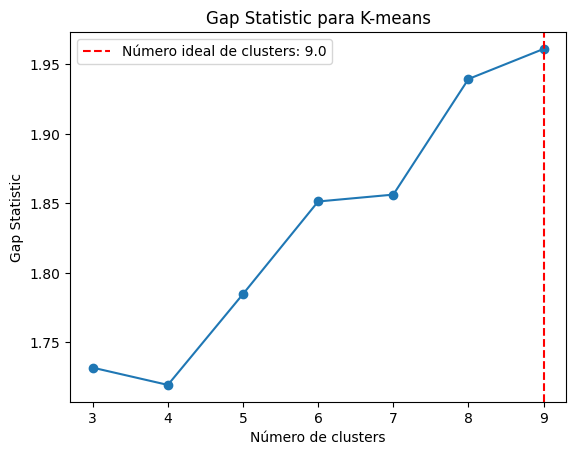

Número ideal de clusters: 9.0
Valores do Gap Statistic:

    qtd_clusters       gap
0           3.0  1.731839
1           4.0  1.719414
2           5.0  1.784787
3           6.0  1.851382
4           7.0  1.856323
5           8.0  1.939489
6           9.0  1.961133


In [4]:
# Definir o conjunto de dados para avaliação do GAP Statistic
# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["Census tract"],axis=1)

# Executar o GAP Statistic para determinar o número ótimo de clusters
melhor_k,indice_maior_gap, resultsDf = gapStatisticMethod(dados.values,max_clusters=10)

# Plotagem dos resultados
plt.plot(resultsDf["qtd_clusters"], resultsDf["gap"], marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic para K-means')
plt.axvline(x=melhor_k, color='red', linestyle='--', label=f'Número ideal de clusters: {melhor_k}')
plt.legend()
plt.show()

# Imprime o número ideal de clusters e os valores do Gap Statistic
print("Número ideal de clusters:", melhor_k)
print("Valores do Gap Statistic:\n\n", resultsDf)

### Utilização do Método de Cotovelo para determinar o número ótimo de clusters

O método do cotovelo (Elbow Method) é uma técnica simples e comum para determinar o número ideal de clusters em um conjunto de dados. 
Consiste em executar o algoritmo de clustering (por exemplo, K-means) para diferentes valores de K e plotar a soma dos quadrados das distâncias intra-cluster em relação ao número de clusters. 

O ponto de "cotovelo" no gráfico é geralmente considerado como o número ideal de clusters.

A lógica por trás do Método do Cotovelo é que, à medida que o número de clusters aumenta, a soma dos quadrados das distâncias intra-cluster diminui. No entanto, em um certo ponto, adicionar mais clusters não leva a uma redução significativa na soma dos quadrados das distâncias intra-cluster. Este ponto é comumente referido como o ponto de "cotovelo".


In [5]:
# Determinar a quantidade ótima de clusters usando o Método de Cotovelo (Elbow Method)
def elbowMethod(data, min_clusters=2, max_clusters=10):
    """
    Implementação do método de cotovelo para encontrar o número ideal de clusters.
    
    Params:
        data: ndarray de forma (n_samples, n_features)
            O conjunto de dados a ser agrupado.
        max_clusters: int, opcional (padrão=10)
            O número máximo de clusters a serem testados.
    
    Return:
        (indice_maior_elbow, resultsDf)
    """
    distortions = []  # Armazena a soma dos quadrados das distâncias intra-cluster
    resultsDf = pd.DataFrame({'qtd_clusters':[], 'distortions':[]})
    
    for i,k in enumerate(range(min_clusters, max_clusters + 1)):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        
        # Armazenar o resultado do soma dos quadrados das distâncias intra-cluster
        distortions.append(kmeans.inertia_) 
        resultsDf.loc[i] = [k, kmeans.inertia_] 
    
    # Encontrar o ponto de cotovelo (método mais simples - procurando a maior inclinação)
    differences = np.diff(distortions)
    indice_melhor_k = np.argmax(differences)
    
    return resultsDf.iloc[indice_melhor_k]["qtd_clusters"],indice_melhor_k, resultsDf, differences


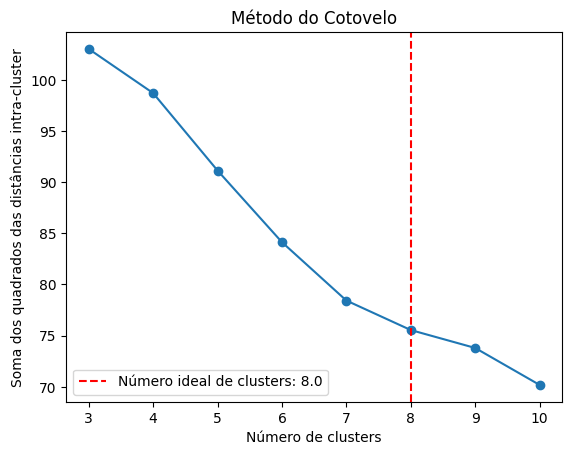

Número ideal de clusters: 8.0
Valores do Elbow Method:

    qtd_clusters  distortions
0           3.0   103.020135
1           4.0    98.703826
2           5.0    91.138721
3           6.0    84.136160
4           7.0    78.431446
5           8.0    75.548386
6           9.0    73.797282
7          10.0    70.186128 
Diferenças: 
           0
0 -4.316309
1 -7.565105
2 -7.002561
3 -5.704714
4 -2.883060
5 -1.751104
6 -3.611154


In [6]:
### Definir o conjunto de dados para avaliação do método de cotovelo
# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["Census tract"],axis=1)
max_clusters=10

# Executar método de cotovelo para determinar o número ótimo de clusters
melhor_k,elbow_index, resultsDf,differences = elbowMethod(dados,min_clusters=3,max_clusters=max_clusters)

plt.plot(resultsDf["qtd_clusters"], resultsDf["distortions"], marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Soma dos quadrados das distâncias intra-cluster')
plt.title('Método do Cotovelo')
plt.axvline(x=melhor_k, color='red', linestyle='--', label=f'Número ideal de clusters: {melhor_k}')  # Adiciona uma linha vertical
plt.legend()
plt.show()

# Imprime o número ideal de clusters e os valores do Gap Statistic
print("Número ideal de clusters:", melhor_k)
print("Valores do Elbow Method:\n\n", resultsDf,"\nDiferenças: \n",pd.DataFrame(differences))


### Utilização do Método Silhouette Score para determinar o número ótimo de clusters

O Silhouette Score é uma medida que avalia a qualidade dos clusters formados por um algoritmo de clustering, como o K-means. 
Ele fornece uma pontuação para cada ponto de dados, indicando o quão bem esse ponto é atribuído ao seu cluster e quão distante ele está dos outros clusters. 
O Silhouette Score varia de -1 a 1, onde valores mais altos indicam uma melhor separação entre os clusters.

In [7]:
def silhouetteScoreMethod(data, min_clusters=3 ,max_clusters=10):
    """
    Implementação do Silhouette Score para determinar o número ideal de clusters usando K-means.
    
    Params:
        data: ndarray de forma (n_samples, n_features)
            O conjunto de dados a ser agrupado.
        min_clusters: int, opcional (padrão=3)
            O número mínimo de clusters a serem testados.
        max_clusters: int, opcional (padrão=10)
            O número máximo de clusters a serem testados.
    
    Return:
        indice_maior_silhueta: int
            O número ideal de clusters com base no Silhouette Score.
        resultsDf: DataFrame
            Dataframe contendo os Silhouette Scores para cada número de clusters testado.
    """
    
    silhouette_scores = []
    resultsDf = pd.DataFrame({'qtd_clusters':[], 'silhouette_score':[]})
    
    for i,k in enumerate(range(min_clusters, max_clusters + 1)):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        # Armazenar o resultado da silhueta média
        silhouette_scores.append(silhouette_avg)
        resultsDf.loc[i] = [k, silhouette_avg] 
    
    indice_melhor_k = np.argmax(silhouette_scores)  
    return resultsDf.iloc[indice_melhor_k]["qtd_clusters"],indice_melhor_k, resultsDf



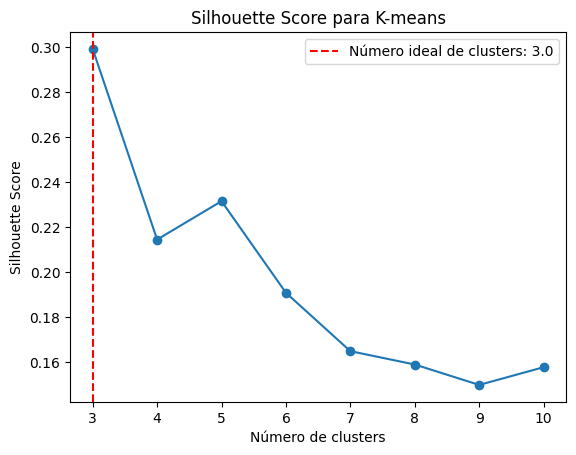

Número ideal de clusters: 3.0
Silhouette Scores:
    qtd_clusters  silhouette_score
0           3.0          0.299054
1           4.0          0.214418
2           5.0          0.231458
3           6.0          0.190779
4           7.0          0.164868
5           8.0          0.158942
6           9.0          0.149881
7          10.0          0.157741


In [8]:
# Definir o conjunto de dados para avaliação do método de silhueta
# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["Census tract"],axis=1)
max_clusters=10

melhor_k,indice_melhor_k, resultsDf = silhouetteScoreMethod(dados,max_clusters=max_clusters)

# Plotagem dos resultados
plt.plot(resultsDf["qtd_clusters"], resultsDf["silhouette_score"], marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para K-means')
plt.axvline(x=melhor_k, color='red', linestyle='--', label=f'Número ideal de clusters: {melhor_k}')
plt.legend()
plt.show()

# Imprime o número ideal de clusters e os Silhouette Scores
print("Número ideal de clusters:", melhor_k)
print("Silhouette Scores:\n", resultsDf)

### Utilização do Método Calinski-Harabasz Index para determinar o número ótimo de clusters

O índice de Calinski-Harabasz é uma métrica interna que avalia a qualidade dos clusters formados por um algoritmo de clustering, como o K-means. 
Ele calcula a razão entre a dispersão intra-cluster e a dispersão inter-cluster. 
Quanto maior o valor do índice de Calinski-Harabasz, melhor a separação entre os clusters.

In [9]:
def calinskiHarabaszIndexMethod(data,min_clusters=3,max_clusters=10):
    """
    Implementação do índice de Calinski-Harabasz para determinar o número ideal de clusters usando K-means.
    
    Params:
        data: ndarray de forma (n_samples, n_features)
            O conjunto de dados a ser agrupado.
        min_clusters: int, opcional (padrão=3)
            O número mínimo de clusters a serem testados.
        max_clusters: int, opcional (padrão=10)
            O número máximo de clusters a serem testados.
    
    Return:
        best_k: int
            O número ideal de clusters com base no índice de Calinski-Harabasz.
        calinski_scores: list
            Lista contendo os índices de Calinski-Harabasz para cada número de clusters testado.
    """
    calinski_scores = []
    resultsDf = pd.DataFrame({'qtd_clusters':[], 'calinski_score':[]})
    
    for i,k in enumerate(range(min_clusters, max_clusters + 1)):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        calinski_score = calinski_harabasz_score(data, cluster_labels)
        
        # Armazenar o resultado dos scores
        calinski_scores.append(calinski_score)
        resultsDf.loc[i] = [k, calinski_score] 
    
    indice_melhor_k = np.argmax(calinski_scores) 
    return resultsDf.iloc[indice_melhor_k]["qtd_clusters"],indice_melhor_k, resultsDf



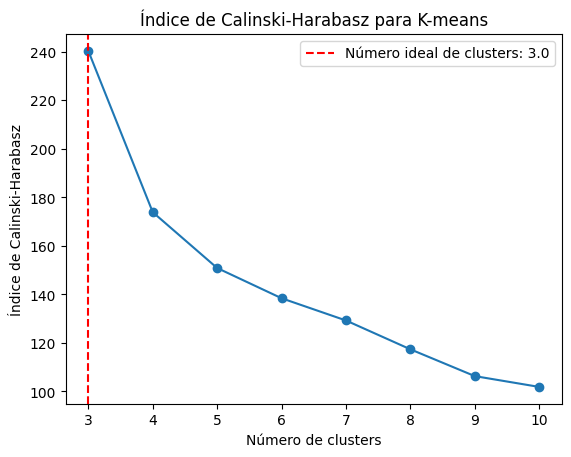

Número ideal de clusters: 3.0
Índices de Calinski-Harabasz:
    qtd_clusters  calinski_score
0           3.0      240.342535
1           4.0      173.868930
2           5.0      150.850324
3           6.0      138.390902
4           7.0      129.224928
5           8.0      117.339153
6           9.0      106.292651
7          10.0      101.838034


In [10]:
# Definir o conjunto de dados para avaliação do método de silhueta
# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["Census tract"],axis=1)
max_clusters=10

melhor_k,indice_melhor_k, resultsDf = calinskiHarabaszIndexMethod(dados)

# Plotagem dos resultados
plt.plot(resultsDf["qtd_clusters"], resultsDf["calinski_score"], marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Índice de Calinski-Harabasz')
plt.title('Índice de Calinski-Harabasz para K-means')
plt.axvline(x=melhor_k, color='red', linestyle='--', label=f'Número ideal de clusters: {melhor_k}')
plt.legend()
plt.show()

# Imprime o número ideal de clusters e os índices de Calinski-Harabasz
print("Número ideal de clusters:", melhor_k)
print("Índices de Calinski-Harabasz:\n", resultsDf)

### Utilização do Davies Bauldin Index para determinar o número ótimo de clusters

O Índice Davies-Bouldin é uma métrica interna usada para avaliar a qualidade dos clusters em um algoritmo de clustering. 
Ele é calculado como a média do grau de similaridade entre cada cluster e seu cluster mais próximo, onde um índice menor indica uma melhor separação entre os clusters.

In [11]:
def daviesBouldinIndexMethod(data, min_clusters=3,max_clusters=10):
    """
    Implementação do Índice Davies-Bouldin para determinar o número ideal de clusters usando K-means.
    
    Params:
        data: ndarray de forma (n_samples, n_features)
            O conjunto de dados a ser agrupado.
        max_clusters: int, opcional (padrão=10)
            O número máximo de clusters a serem testados.
    
    Return:
        best_k: int
            O número ideal de clusters com base no Índice Davies-Bouldin.
        davies_bouldin_scores: list
            Lista contendo os Índices Davies-Bouldin para cada número de clusters testado.
    """
    davies_bouldin_scores = []
    resultsDf = pd.DataFrame({'qtd_clusters':[], 'davies_bouldin_score':[]})
    for i,k in enumerate(range(min_clusters, max_clusters + 1)):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        davies_bouldin_score_value = davies_bouldin_score(data, cluster_labels)

        # Armazenar o resultado dos scores
        davies_bouldin_scores.append(davies_bouldin_score_value)
        resultsDf.loc[i] = [k, davies_bouldin_score_value] 
    
    indice_melhor_k = np.argmin(davies_bouldin_scores) 
    return resultsDf.iloc[indice_melhor_k]["qtd_clusters"],indice_melhor_k, resultsDf


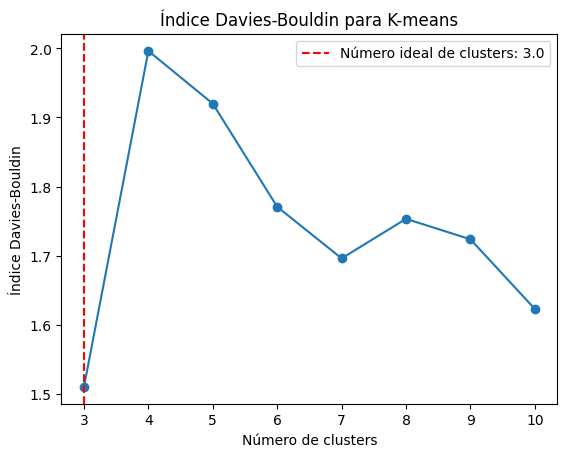

Número ideal de clusters: 3.0
Índices Davies-Bouldin: 
 0    1.510340
1    1.996276
2    1.919999
3    1.770852
4    1.696242
5    1.753404
6    1.723844
7    1.623076
Name: davies_bouldin_score, dtype: float64


In [13]:
# Definir o conjunto de dados para avaliação do método de silhueta
# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["Census tract"],axis=1)
max_clusters=10

melhor_k,indice_melhor_k, resultsDf = daviesBouldinIndexMethod(dados)

# Plotagem dos resultados
plt.plot(resultsDf["qtd_clusters"], resultsDf["davies_bouldin_score"], marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Índice Davies-Bouldin')
plt.title('Índice Davies-Bouldin para K-means')
plt.axvline(x=melhor_k, color='red', linestyle='--', label='Número ideal de clusters: {}'.format(melhor_k))
plt.legend()
plt.show()

# Imprime o número ideal de clusters e os Índices Davies-Bouldin
print("Número ideal de clusters:", melhor_k)
print("Índices Davies-Bouldin: \n", resultsDf["davies_bouldin_score"])

In [14]:
# Definir o conjunto de dados para avaliação do método de silhueta
# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["Census tract"],axis=1)

min_clusters=4
max_clusters=7

resultadosMetodos=pd.DataFrame({'metodo':[] ,'qtd_clusters':[]})

res_gap_stats = gapStatisticMethod(dados,min_clusters=min_clusters,max_clusters=max_clusters)
res_elbow = elbowMethod(dados,min_clusters=min_clusters,max_clusters=max_clusters)
res_calinski=calinskiHarabaszIndexMethod(dados,min_clusters=min_clusters,max_clusters=max_clusters)
res_davies= daviesBouldinIndexMethod(dados,min_clusters=min_clusters,max_clusters=max_clusters)
res_silhouett=silhouetteScoreMethod(dados,min_clusters=min_clusters,max_clusters=max_clusters)

resultadosMetodos.loc[len(resultadosMetodos.index)] = ['Gap Statistc',res_gap_stats[0] ] 
resultadosMetodos.loc[len(resultadosMetodos.index)] = ['Elbow',res_elbow[0] ]  
resultadosMetodos.loc[len(resultadosMetodos.index)] = ['Calinski',res_calinski[0] ]  
resultadosMetodos.loc[len(resultadosMetodos.index)] = ['Davies',res_davies[0] ]  
resultadosMetodos.loc[len(resultadosMetodos.index)] = ['Silhouette',res_silhouett[0] ]  


resultadosMetodos

,metodo,qtd_clusters
0,Gap Statistc,6.0
1,Elbow,6.0
2,Calinski,4.0
3,Davies,7.0
4,Silhouette,5.0


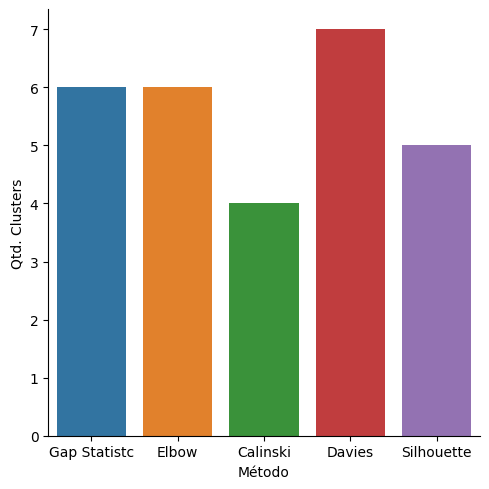

In [15]:
import seaborn as sns

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=resultadosMetodos, 
    kind="bar",
    x="metodo", 
    y="qtd_clusters", palette="tab10",hue="metodo"
)

g.set_axis_labels("Método", "Qtd. Clusters")
# g.legend.set_title("Avaliacão métodos definição melhor número de Clusters")